# Model Training

Initial model using aggregated and condensed headline data

Target: S&P500 trend after 1 day

In [1]:
!pip install datasets wandb transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset("csv", data_files="jvdm_aggregated_data.csv" )
dataset = dataset.remove_columns([col for col in dataset["train"].column_names if col not in ["Headlines_Condensed", "TrendD+1"]])
dataset = dataset.rename_column("TrendD+1", "labels")

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
train_test_split = dataset["train"].train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [5]:
print(train_dataset[0])
print(test_dataset[0])

{'labels': 2, 'Headlines_Condensed': 'japan docomo resume orders huawei p pro smartphones climate change could rain saudi aramco ipo parade ubs names new ceo european union operations lufthansa hold ground short haul price war exclusive whatsapp talks launch mobile payments indonesia sources humbled deutsche bank faces battle backyard top u ceos say companies put social responsibility profit qualcomm strikes licensing deal lg mercedes reviews vans model portfolio diesel debate hammers sales lotus midstream mulls reversing west texas cushing pipeline founder details mode reform plan beat crisis nuclear regulator permits restarting reactor hunterston b asos asks suppliers discount effort repair finances first thoughts real consequence brexit not term shock long recession natwest rbs customers hit credit card glitch persimmon profits fall housebuilder looks repairing reputation amazon fire packaging cannot recycled national grid blames lightning strike blackout world stocks rally trump st

In [6]:
label_list = dataset["train"].unique("labels")
num_labels = len(label_list)

### Load tokenizer

In [7]:
from transformers import AutoTokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [9]:
train_dataset = train_dataset.map(lambda x: tokenizer(x["Headlines_Condensed"], truncation=True), batched=True)
test_dataset = test_dataset.map(lambda x: tokenizer(x["Headlines_Condensed"], truncation=True), batched=True)

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

### Load pretrained model

In [10]:
from transformers import AutoModelForSequenceClassification

In [11]:
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", num_labels=num_labels)

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

### Train model

In [12]:
from transformers import Trainer, TrainingArguments

In [ ]:
import wandb
wandb.login()

In [14]:
training_args = TrainingArguments(
    report_to="wandb",
    output_dir="sp500-d1-aggregated-colab",
    overwrite_output_dir=True,
    eval_strategy="steps",
    learning_rate=1e-5,
    max_steps=10000,
    logging_steps=100,
    eval_steps=1000,
    save_steps=2000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    run_name="SP500-Predictor-D1-Aggregated-colab"
)

In [15]:
from datasets import load_metric
import numpy as np

In [16]:
accuracy_metric = load_metric("accuracy")

<ipython-input-16-b26f5846bd21>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [17]:
def custom_metric(eval_pred):

    predictions, labels = eval_pred

    # [0.3, 0.1, 0.2, 0.1, 0.1, 0.1, 0.5, 0.2] -> 6
    predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=custom_metric
)

max_steps is given, it will override any value given in num_train_epochs


In [19]:
trainer.train()

wandb: Currently logged in as: jeroenvdmbrugge (jeroenvdmbrugge-personal). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
1000,0.373200,2.740433,0.438503
2000,0.053600,4.147567,0.513369
3000,0.015800,4.457119,0.529412
4000,0.023400,4.399416,0.561497
5000,0.031600,5.078817,0.513369
6000,0.005800,4.603441,0.572193
7000,0.007800,5.017095,0.545455
8000,0.000200,5.574042,0.502674
9000,0.000100,5.174819,0.561497
10000,0.000000,5.347457,0.550802


TrainOutput(global_step=10000, training_loss=0.09669920723558753, metrics={'train_runtime': 4270.2187, 'train_samples_per_second': 18.734, 'train_steps_per_second': 2.342, 'total_flos': 1.0593416363807808e+16, 'train_loss': 0.09669920723558753, 'epoch': 107.52688172043011})

In [20]:
from google.colab import drive
drive.mount('/content/drive')

model.save_pretrained('/content/drive/MyDrive/sp500_model')
tokenizer.save_pretrained('/content/drive/MyDrive/sp500_model')

Mounted at /content/drive


('/content/drive/MyDrive/sp500_model/tokenizer_config.json',
 '/content/drive/MyDrive/sp500_model/special_tokens_map.json',
 '/content/drive/MyDrive/sp500_model/vocab.json',
 '/content/drive/MyDrive/sp500_model/merges.txt',
 '/content/drive/MyDrive/sp500_model/added_tokens.json',
 '/content/drive/MyDrive/sp500_model/tokenizer.json')

In [23]:
trainer.save_model('/content/drive/MyDrive/sp500_model_trainer')
trainer.state.save_to_json('/content/drive/MyDrive/sp500_model_trainer/trainer_state.json')

### Evaluate the model on the test dataset

In [24]:
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")


Evaluation Results: {'eval_loss': 4.603440761566162, 'eval_accuracy': 0.5721925133689839, 'eval_runtime': 3.3836, 'eval_samples_per_second': 55.267, 'eval_steps_per_second': 7.093, 'epoch': 107.52688172043011}


In [25]:
predictions = trainer.predict(test_dataset)

# Extract predictions and labels
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Print a sample of predictions vs actual labels
for i in range(10):
    print(f"Prediction: {pred_labels[i]}, Actual: {true_labels[i]}")


Prediction: 1, Actual: 2
Prediction: 1, Actual: 1
Prediction: 1, Actual: 0
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 2, Actual: 2
Prediction: 1, Actual: 0
Prediction: 2, Actual: 1
Prediction: 1, Actual: 1


### Confusion matrix

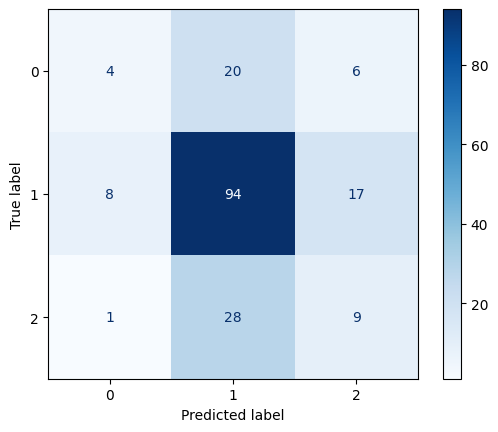

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")


In [27]:
wandb.log(eval_results)